<a href="https://colab.research.google.com/github/Laura9704/Fundamentos_MCD/blob/main/Modelo_con_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#libreria

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #gráficos
import matplotlib.dates as mdates
pd.set_option('display.max_columns', None)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from math import sqrt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense # Se usa SimpleRNN o la capa RNN que elijas
from tensorflow.keras.optimizers import Adam

# Importa librerías para imputación
from scipy.interpolate import interp1d

import random
import os
import warnings
warnings.filterwarnings('ignore')

## Cargar desde Kaggle

In [3]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"svlauracarolinasv","key":"2d7513d4cd31b4367dc2a650087afced"}'}

In [43]:
import sys
!mkdir -p ~/.kaggle
!mv "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
import zipfile
# --- PASO 1: Descargar y Descomprimir ---
competition_name = 'fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn'
zip_file_name = f'{competition_name}.zip'

print(f"1. Descargando datos de la competición: {competition_name}...")
# El comando !kaggle descarga el archivo ZIP. El flag -p /content/ lo coloca en la raíz.
!kaggle competitions download -c {competition_name} -p /content/

# Descomprimir el archivo ZIP
print(f"2. Descomprimiendo archivos...")
try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        # Extraer todo el contenido a la carpeta actual (/content/)
        zip_ref.extractall('/content/')
    print("Descompresión completada. Archivos Parquet listos.")
except FileNotFoundError:
    print(f"\n[ERROR] No se encontró el archivo ZIP: {zip_file_name}")
    print("Asegúrate de que la descarga fue exitosa.")
    exit()

# --- PASO 2: Cargar df_train y df_test usando pd.read_parquet ---
try:
    # Cargar el set de entrenamiento
    df_train = pd.read_parquet('df_train.parquet')
    print(f"\n3. df_train cargado (Parquet). Shape: {df_train.shape}")

    # Cargar el set de prueba (test)
    df_test = pd.read_parquet('df_test.parquet')
    print(f"   df_test cargado (Parquet). Shape: {df_test.shape}")

except Exception as e:
    print("\n[ERROR] No se pudieron cargar 'df_train.parquet' o 'df_test.parquet'.")
    print(f"Detalle del error: {e}")

mv: cannot stat 'kaggle (1).json': No such file or directory
1. Descargando datos de la competición: fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn...
fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn.zip: Skipping, found more recently modified local copy (use --force to force download)
2. Descomprimiendo archivos...
Descompresión completada. Archivos Parquet listos.

3. df_train cargado (Parquet). Shape: (8932, 10)
   df_test cargado (Parquet). Shape: (184, 9)


In [44]:
df_train.head()

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation
0,2000-01-01,20.1,23.1,27.5,57.0,77.0,95.0,308.1,2.8,0.0
1,2000-01-02,19.2,22.0,26.7,58.0,82.0,98.0,343.1,4.1,0.0
2,2000-01-03,18.0,21.7,28.8,51.0,80.0,98.0,456.1,4.5,2.1
3,2000-01-04,17.8,21.9,27.1,50.0,74.0,90.0,391.5,3.8,0.0
4,2000-01-05,19.0,22.3,27.4,51.0,76.0,95.0,348.4,3.9,0.0


In [6]:
df_train.isnull().sum()

,0
date,0
min_temp,56
avg_temp,57
max_temp,54
min_rel_humidity,94
avg_rel_humidity,92
max_rel_humidity,51
solar_radiation,88
evapotranspiration,1000
precipitation,0


In [7]:
df_test.head()

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration
0,2024-07-01,17.4,23.4,31.1,49.0,83.0,100.0,529.7,4.3
1,2024-07-02,20.2,23.7,29.8,61.0,85.0,100.0,396.5,3.3
2,2024-07-03,20.9,23.7,30.1,55.0,86.0,100.0,359.3,3.0
3,2024-07-04,19.5,22.7,28.9,63.0,91.0,100.0,304.8,2.4
4,2024-07-05,18.8,20.8,24.4,76.0,96.0,100.0,241.0,1.9


In [8]:
df_test.isnull().sum()

,0
date,0
min_temp,0
avg_temp,0
max_temp,0
min_rel_humidity,0
avg_rel_humidity,0
max_rel_humidity,0
solar_radiation,0
evapotranspiration,0


In [33]:
df=df_train.copy()

## CARGA DE ARCHIVOS DESDE DRIVE

In [ ]:
'''
# CARGAR df_train.parquet
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/MCD/MCD_FDA_II/TALLER 2_RNN/fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn/df_train.parquet'
df = pd.read_parquet(file_path)
'''

"\n# CARGAR df_train.parquet\nimport pandas as pd\nfrom google.colab import drive\ndrive.mount('/content/drive')\nfile_path = '/content/drive/My Drive/MCD/MCD_FDA_II/TALLER 2_RNN/fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn/df_train.parquet'\ndf = pd.read_parquet(file_path)\n"

# Imputacion del DATA

Diferencias entre imputación por media estacional e interpolación

**1. Imputación por estacionaliladad**

  *  **Qué hace:** Reemplaza valores faltantes con el promedio de valores observados en la misma estación/período (por ejemplo, todos los eneros, o todos los lunes, o la misma semana del año)
  *  **Supuesto:** Los datos tienen patrones estacionales recurrentes y el valor faltante debería parecerse al comportamiento típico de ese período
  *  **Resultado:** Introduce un valor "promedio" o "típico" que no considera la tendencia local ni los valores inmediatamente adyacentes
  *  **Ventaja:** Preserva patrones estacionales y es útil cuando hay ciclos claros (temperatura, ventas navideñas)
  *  **Desventaja:** Ignora la continuidad temporal local; puede crear saltos bruscos si el período actual es atípico

**2. Interpolación**

  *  **Qué hace:** Estima valores faltantes basándose en los valores observados más cercanos en el tiempo (anterior y posterior)
  *  **Supuesto:** Existe continuidad temporal y el valor faltante debería ser una transición suave entre sus vecinos
  *  **Métodos comunes:** Lineal (línea recta entre puntos), spline (curva suave), polinomial y time
  *  **Resultado:** Crea una transición continua que respeta la tendencia local
  *  **Ventaja:** Mantiene la continuidad de la serie y refleja mejor cambios graduales o tendencias
  *  **Desventaja:** No considera patrones estacionales; puede fallar si hay cambios abruptos reales



##Forma 1: Combinadondo
en esta imputacion toma en cuanta el largo de los huecos dentro de las variables del Data, que son mayores a 4 toma el de estacionalidad.

In [34]:
# -------------------------------
# FUNCIONES
# -------------------------------

def mask_long_nan_blocks(series, min_len=4):
    """
    Devuelve una máscara booleana para los NaN consecutivos con longitud mínima `min_len`.
    """
    is_nan = series.isna()
    mask = pd.Series(False, index=series.index)
    count = 0
    for i in range(len(series)):
        if is_nan.iloc[i]:
            count += 1
        else:
            if count >= min_len:
                mask.iloc[i - count:i] = True
            count = 0
    # Para el final de la serie
    if count >= min_len:
        mask.iloc[len(series) - count:] = True
    return mask

# -------------------------------
# Index de dates
# -------------------------------

df = df.set_index('date')
df.index = pd.to_datetime(df.index)

# -------------------------------
# VARIABLES A PROCESAR
# -------------------------------

columns_to_process = [
    'avg_temp', 'max_temp', 'min_temp',
    'avg_rel_humidity', 'max_rel_humidity', 'min_rel_humidity',
    'solar_radiation', 'evapotranspiration'
]

# Crear columna auxiliar: día del año (1-365)
df['dayofyear'] = df.index.dayofyear

# Definir un umbral superior basado en el conocimiento del dominio.
# Si 6999 es claramente un error, podemos usar un umbral conservador (e.g., 20)
UMBRAL_SUPERIOR = 20

# Reemplazar el valor atípico (outlier) con NaN
# Esto es esencial antes de la imputación estacional
df.loc[df['evapotranspiration'] > UMBRAL_SUPERIOR, 'evapotranspiration'] = None # Usamos 'None' o np.nan

print(f"Valores de evapotranspiration > {UMBRAL_SUPERIOR} han sido convertidos a NaN.")

# -------------------------------
# IMPUTACIÓN HÍBRIDA
# -------------------------------

for col in columns_to_process:
    series = df[col].copy()

    # 1. Identificar bloques largos
    long_nan_mask = mask_long_nan_blocks(series, min_len=4)

    # 2. Interpolación para bloques cortos
    series[~long_nan_mask] = series[~long_nan_mask].interpolate(limit=3, limit_direction='both')

    # 3. Estacionalidad por día del año para los valores restantes
    if series.isna().sum() > 0:
        series = series.fillna(df.groupby('dayofyear')[col].transform('mean'))

    # Reasignar al DataFrame original
    df[col] = series

# Eliminar columna auxiliar
df.drop(columns='dayofyear', inplace=True)

# -------------------------------
# REVISIÓN FINAL
# -------------------------------

print("Valores faltantes después de imputación:")
print(df[columns_to_process].isna().sum())


Valores de evapotranspiration > 20 han sido convertidos a NaN.
Valores faltantes después de imputación:
avg_temp              0
max_temp              0
min_temp              0
avg_rel_humidity      0
max_rel_humidity      0
min_rel_humidity      0
solar_radiation       0
evapotranspiration    0
dtype: int64


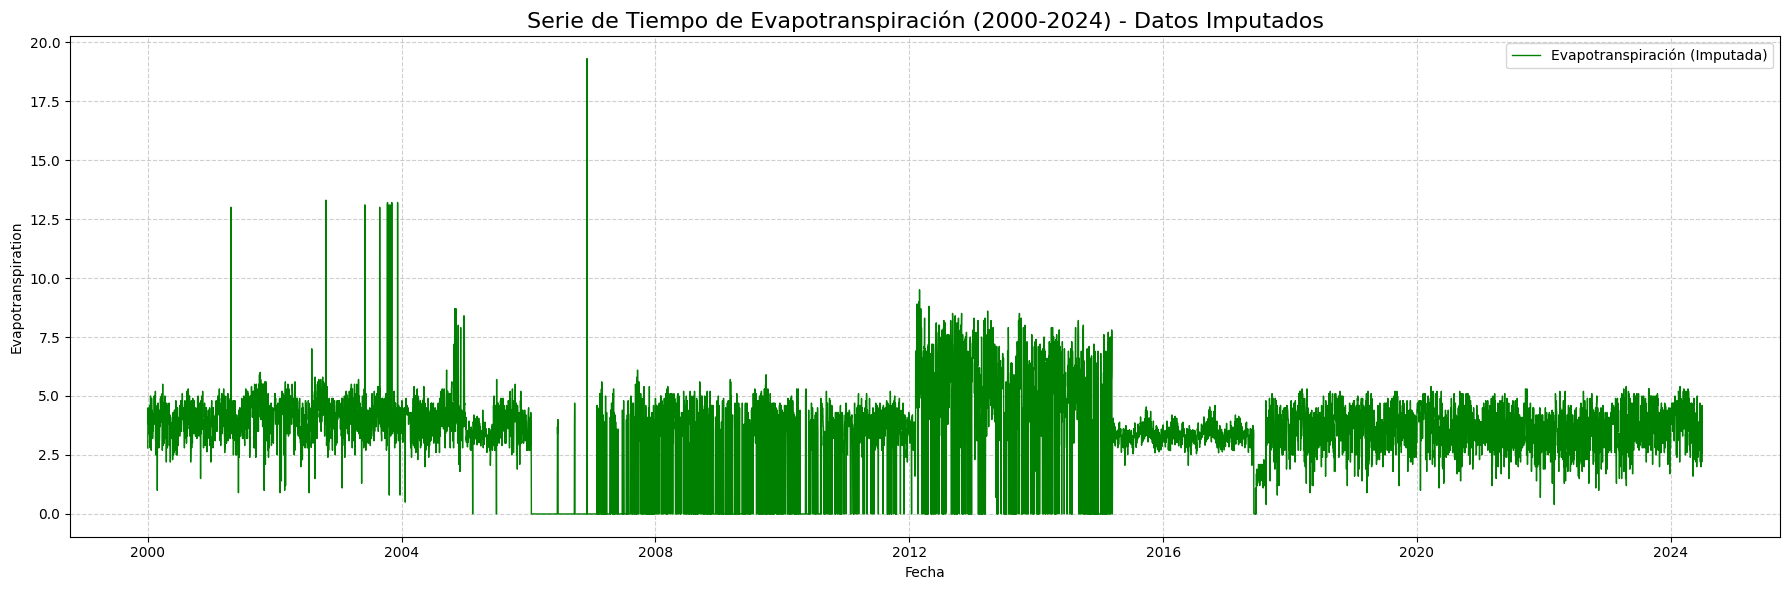


--- Verificación en la Brecha (2015-2018) ---


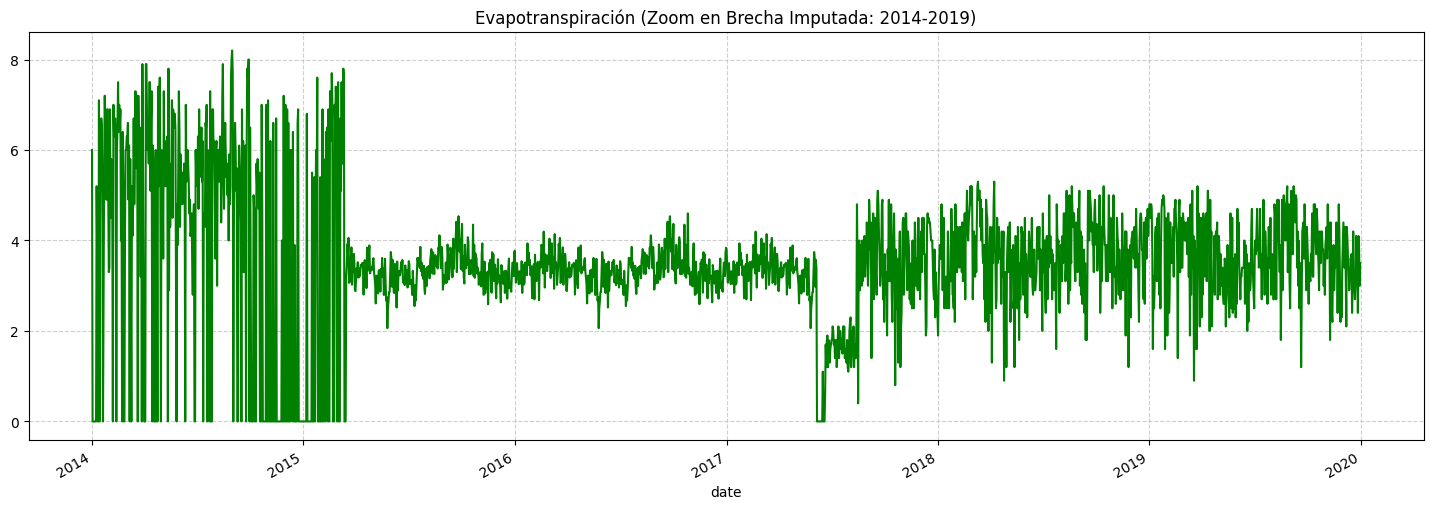

In [37]:
df_imputado=df.copy()
df=df_train.copy()
if not isinstance(df_imputado.index, pd.DatetimeIndex):
    # Esto es solo una verificación de seguridad si el índice no está configurado
    if 'date' in df_imputado.columns:
        df_imputado = df_imputado.set_index('date')
    df_imputado.index = pd.to_datetime(df_imputado.index)

# 2. Generar el gráfico
plt.figure(figsize=(18, 6))

# Grafica la serie completa. Ahora no habrá saltos ni NaN.
plt.plot(df_imputado.index,
         df_imputado['evapotranspiration'],
         color='green', # Usamos un color distinto para diferenciar de los gráficos originales
         linewidth=1.0,
         label='Evapotranspiración (Imputada)')

# 3. Formato y Título
plt.title("Serie de Tiempo de Evapotranspiración (2000-2024) - Datos Imputados", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Evapotranspiration")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4. (Opcional) Zoom para verificar la imputación en la zona 2015-2018
print("\n--- Verificación en la Brecha (2015-2018) ---")
plt.figure(figsize=(18, 6))
df_imputado.loc['2014':'2019', 'evapotranspiration'].plot(
    color='green', linewidth=1.5,
    title='Evapotranspiración (Zoom en Brecha Imputada: 2014-2019)'
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [56]:
# Definir las fechas límite
start_date = '2015-04-16'
end_date = '2015-04-20'

# 1. Asegúrate de que la columna 'date' sea de tipo datetime
# df_train['date'] = pd.to_datetime(df_train['date'])

# 2. Filtrar usando la columna 'date'
df_periodo = df_train[
    (df_train['date'] >= start_date) &
    (df_train['date'] <= end_date)
].copy()
df_periodo

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation
5568,2015-04-16,19.2,22.7,30.1,36.0,78.0,97.0,502.8,NaN,1.8
5569,2015-04-17,18.3,22.1,28.4,43.0,81.0,97.0,388.9,NaN,9.7
5570,2015-04-18,18.9,24.0,30.7,40.0,75.0,97.0,475.3,NaN,0.0
5571,2015-04-19,18.3,22.7,29.3,41.0,78.0,98.0,487.5,NaN,38.4
5572,2015-04-20,18.5,23.1,28.7,50.0,79.0,99.0,381.1,NaN,28.8


In [53]:
df_imputado = df_imputado.round(1)
df_imputado.loc['2015-04-16':'2015-04-20']

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation
date,,,,,,,,,
2015-04-16,19.2,22.7,30.1,36.0,78.0,97.0,502.8,3.4,1.8
2015-04-17,18.3,22.1,28.4,43.0,81.0,97.0,388.9,3.6,9.7
2015-04-18,18.9,24.0,30.7,40.0,75.0,97.0,475.3,3.0,0.0
2015-04-19,18.3,22.7,29.3,41.0,78.0,98.0,487.5,3.5,38.4
2015-04-20,18.5,23.1,28.7,50.0,79.0,99.0,381.1,2.9,28.8
